In [1]:
import arviz as az
import numpy as np  # For vectorized math operations
import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
plt.rcParams["font.family"] = "Latin Modern Roman"

rng = np.random.default_rng(42)

# Use a standard dataset for this example

In [3]:
try:
    wide_heating_df = pd.read_csv("../data/heating_data_r.csv")
except:
    wide_heating_df = pd.read_csv(pm.get_data("heating_data_r.csv"))

wide_heating_df[wide_heating_df["idcase"] == 1]

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region
0,1,gc,866.0,962.64,859.9,995.76,1135.5,199.69,151.72,553.34,505.6,237.88,7,25,6,ncostl


In [4]:
# pivoted data that is more amenable to analysis
 
try:
    long_heating_df = pd.read_csv("../data/long_heating_data.csv")
except:
    long_heating_df = pd.read_csv(pm.get_data("long_heating_data.csv"))

columns = [c for c in long_heating_df.columns if c != "Unnamed: 0"]
long_heating_df[long_heating_df["idcase"] == 1][columns]

,idcase,alt_id,choice,depvar,income,agehed,rooms,region,installation_costs,operating_costs
0,1,1,1,gc,7,25,6,ncostl,866.00,199.69
1,1,2,0,gc,7,25,6,ncostl,962.64,151.72
2,1,3,0,gc,7,25,6,ncostl,859.90,553.34
3,1,4,0,gc,7,25,6,ncostl,995.76,505.60
4,1,5,0,gc,7,25,6,ncostl,1135.50,237.88


Sampling: [beta_ic, beta_oc, y_cat]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y_cat]


Output()

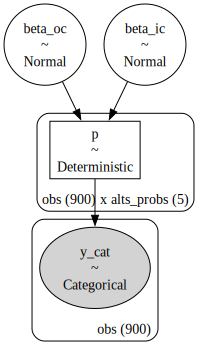

In [5]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
coords = {
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model_1:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)

    ## Construct Utility matrix and Pivot
    u0 = beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=101)
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model_1)

In [6]:
idata_m1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [7]:
summaries = az.summary(idata_m1, var_names=["beta_ic", "beta_oc"])
summaries # results are sus because beta_ic and beta_oc should both be negative

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.002,0.0,0.002,0.002,0.0,0.0,1802.0,2209.0,1.0
beta_oc,-0.004,0.0,-0.005,-0.004,0.0,0.0,983.0,1241.0,1.0


In [8]:
## marginal rate of substitution for a reduction in installation costs
post = az.extract(idata_m1)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

-2.211196691253724

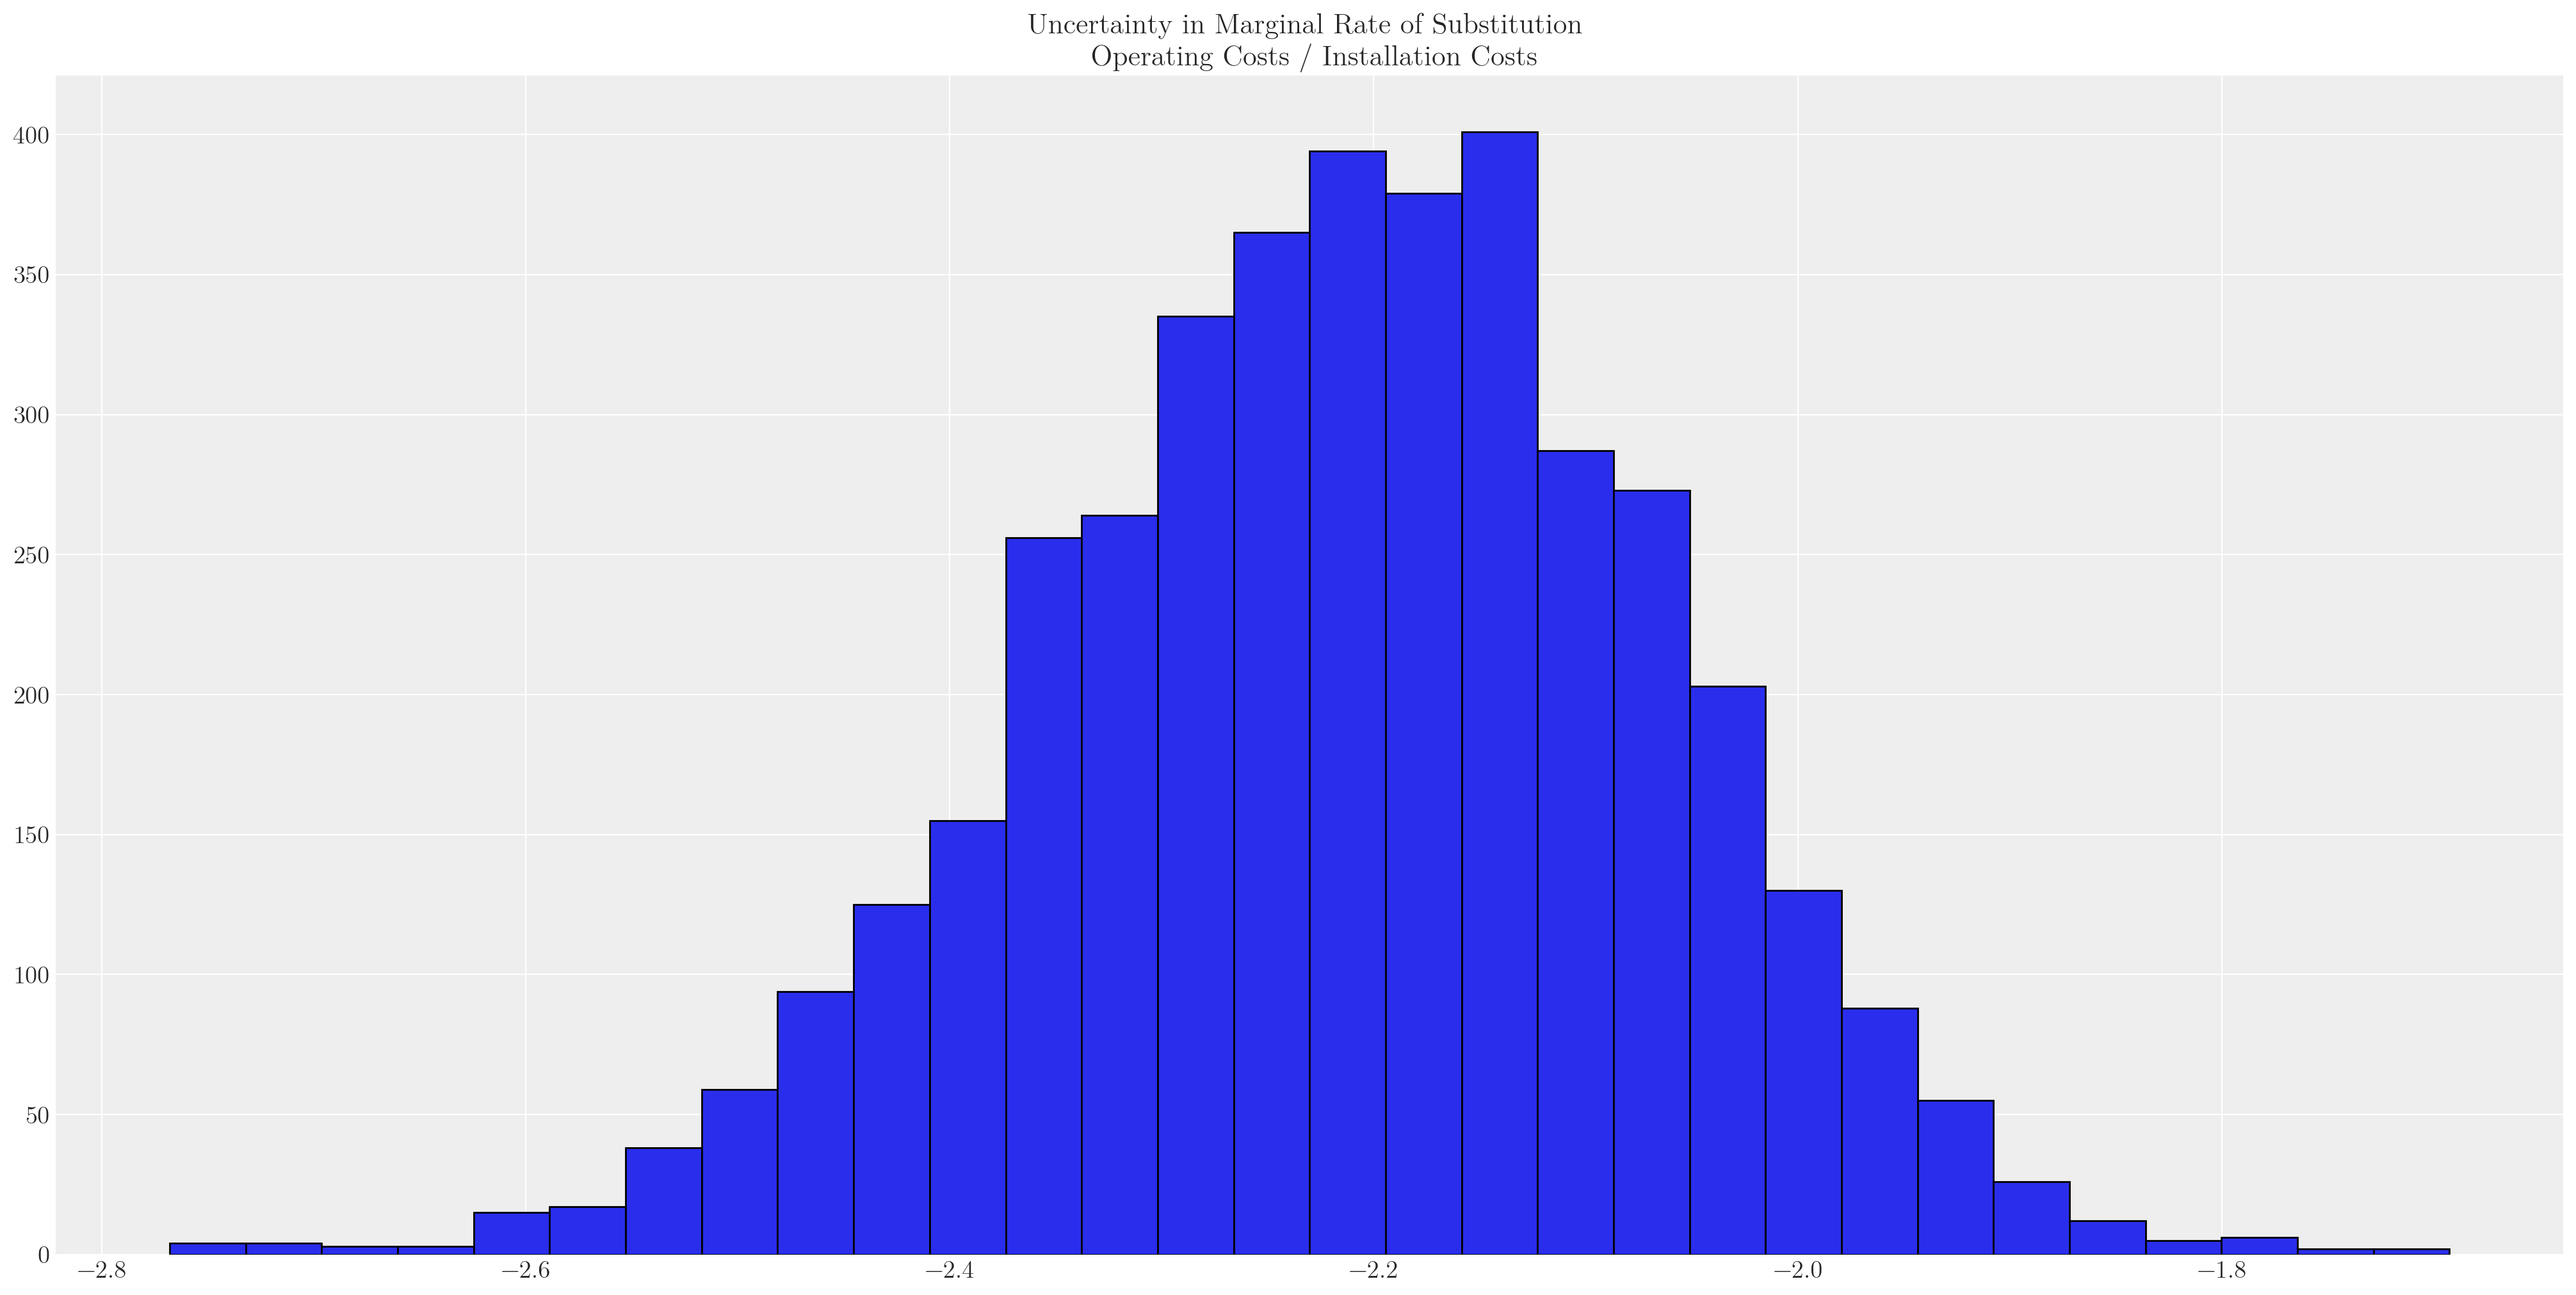

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");
plt.show()

In [10]:
idata_m1["posterior"]["p"].mean(dim=["chain", "draw", "obs"])

<xarray.DataArray 'p' (alts_probs: 5)> Size: 40B
array([0.08432415, 0.13772203, 0.26912233, 0.38199249, 0.12683901])
Coordinates:
  * alts_probs  (alts_probs) <U2 40B 'ec' 'er' 'gc' 'gr' 'hp'

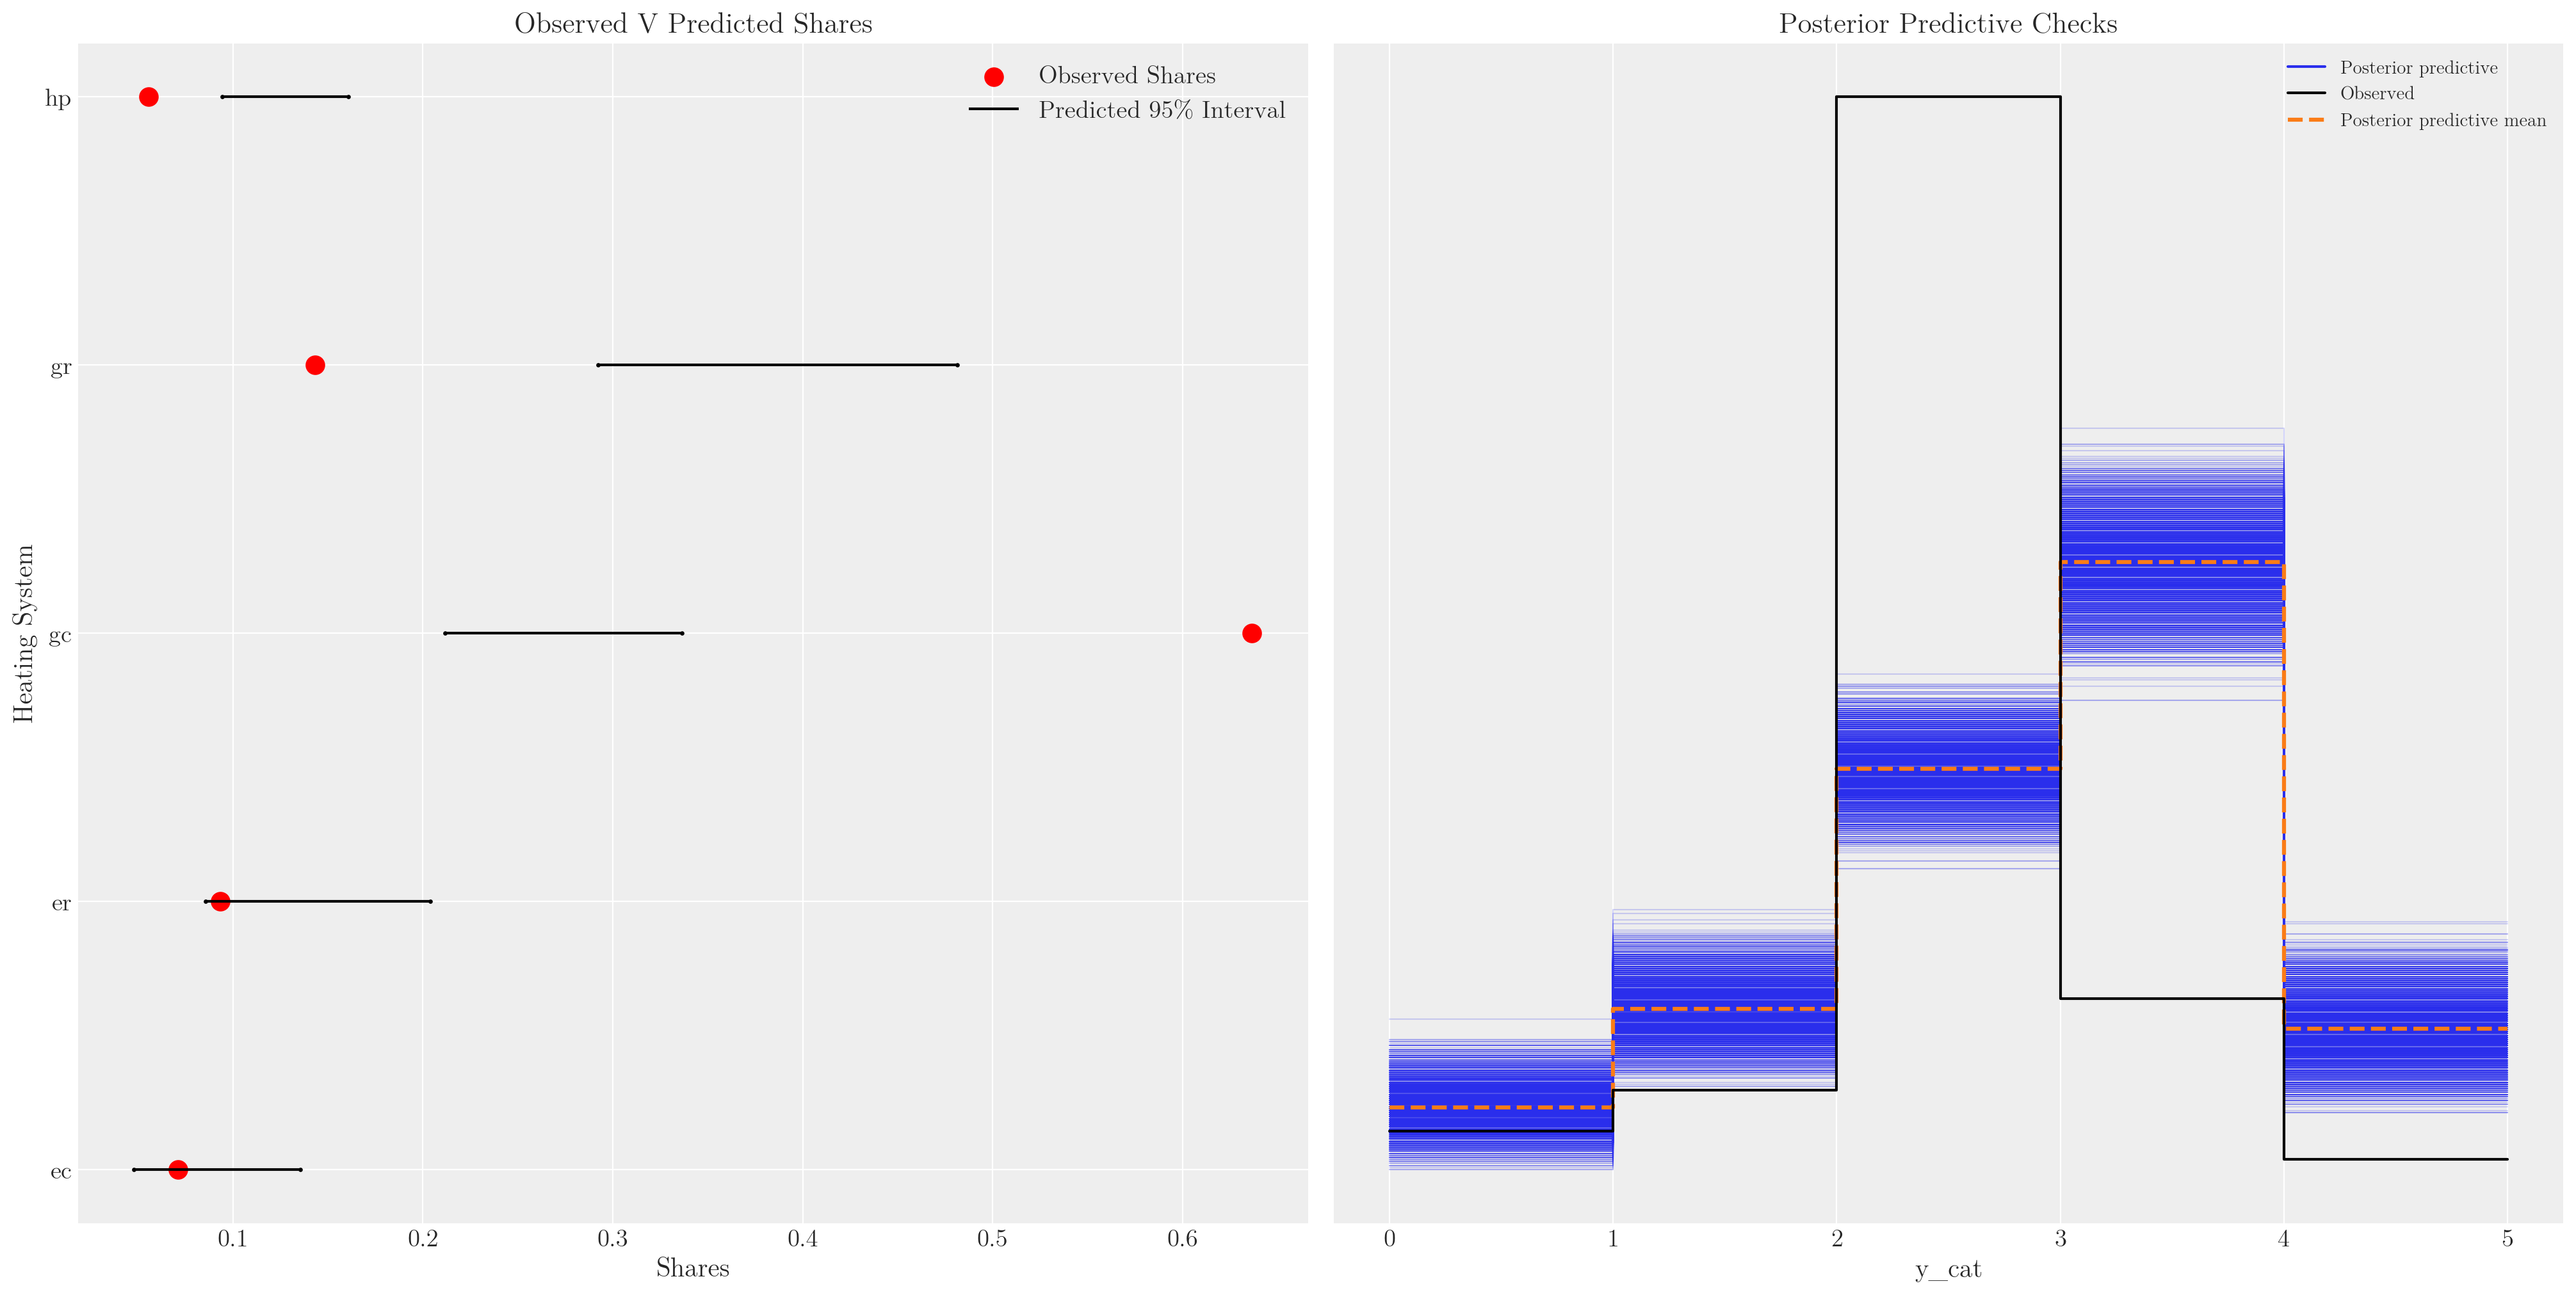

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m1["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m1["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m1["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m1, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

# Getting a better fit

You can improve the fit by adding a good-specific intercept -- intuitively this should allow you to match the observed frequencies

Sampling: [alpha, beta_ic, beta_oc, y_cat]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y_cat]


Output()

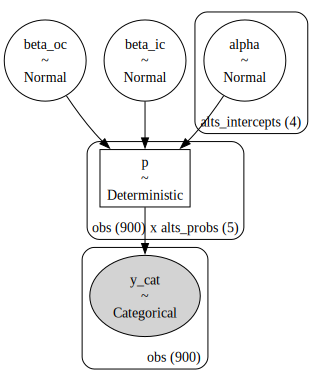

In [12]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes

coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_2:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m2 = pm.sample_prior_predictive()
    idata_m2.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m2.extend(pm.sample_posterior_predictive(idata_m2))


pm.model_to_graphviz(model_2)

In [13]:
az.summary(idata_m2, var_names=["beta_ic", "beta_oc", "alpha"])

# model is still terrible, installation costs and operational costs are meaningless, it's all about the intercepts

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.001,0.000,-0.000,0.002,0.000,0.000,1324.0,1904.0,1.00
beta_oc,-0.003,0.001,-0.005,-0.001,0.000,0.000,1337.0,1785.0,1.00
alpha[ec],1.063,0.513,0.087,2.054,0.017,0.012,914.0,1150.0,1.00
alpha[er],1.102,0.491,0.135,2.017,0.017,0.012,856.0,900.0,1.01
alpha[gc],2.397,0.320,1.826,3.019,0.011,0.008,874.0,1002.0,1.01
alpha[gr],0.760,0.385,0.036,1.448,0.012,0.009,957.0,1124.0,1.01


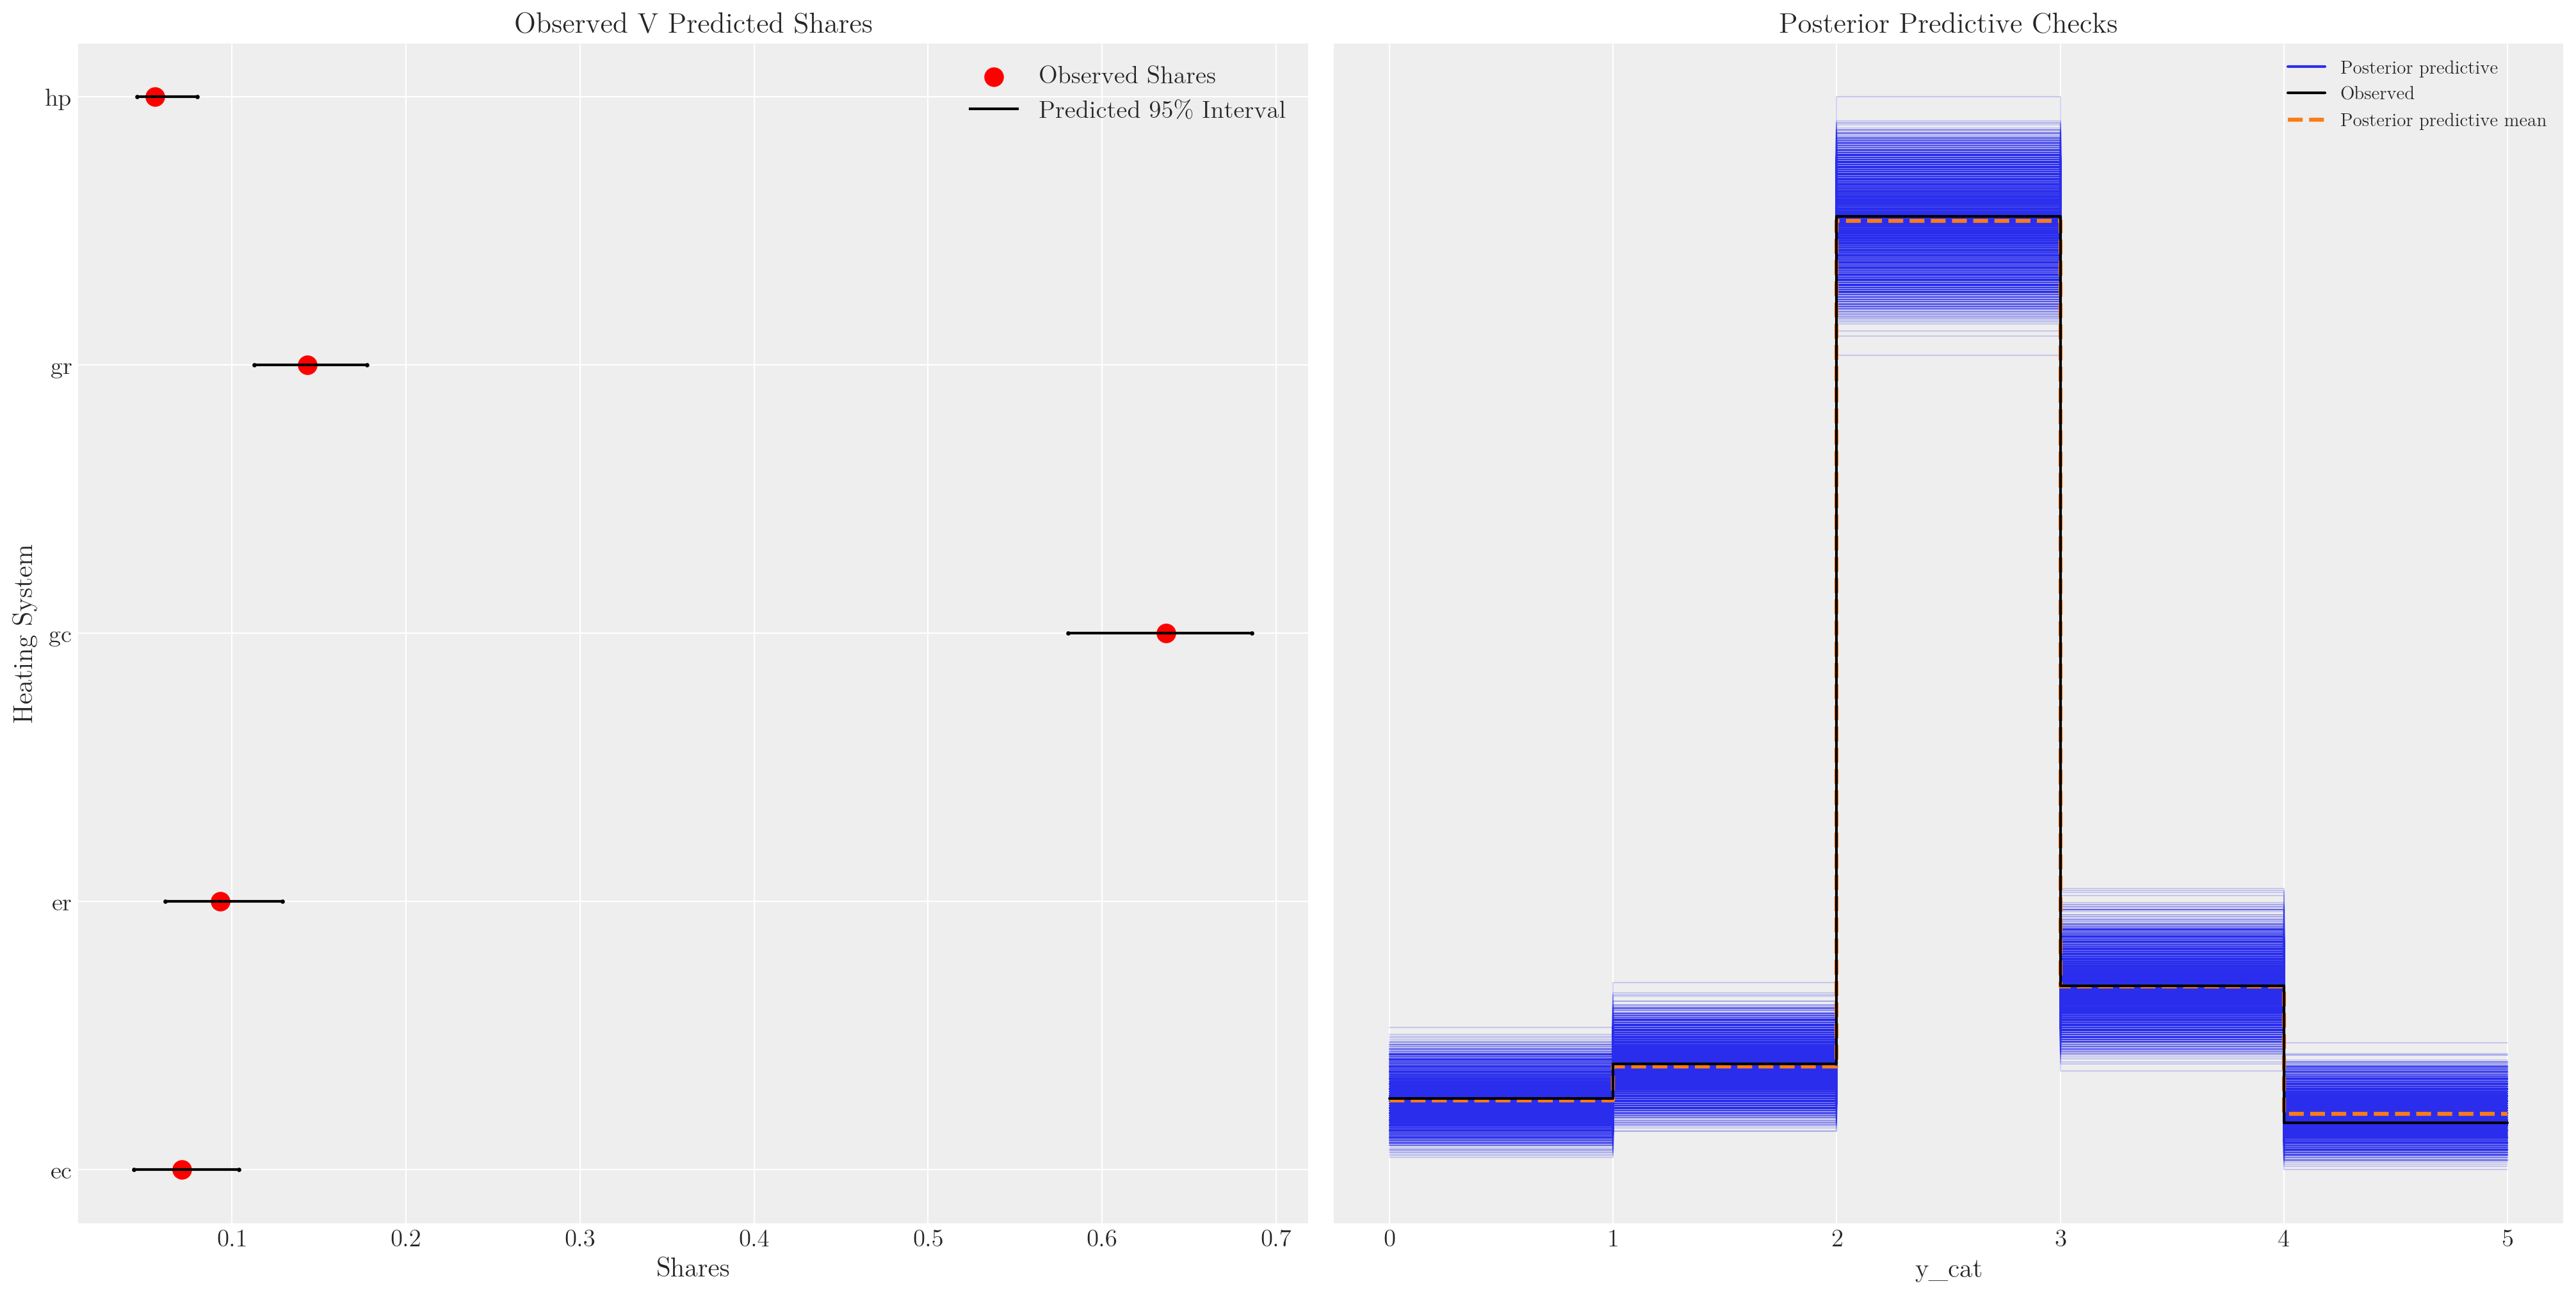

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m2["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m2["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m2["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m2, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [15]:
## marginal rate of substitution for a reduction in installation costs
post = az.extract(idata_m2)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

-11.215830921463027

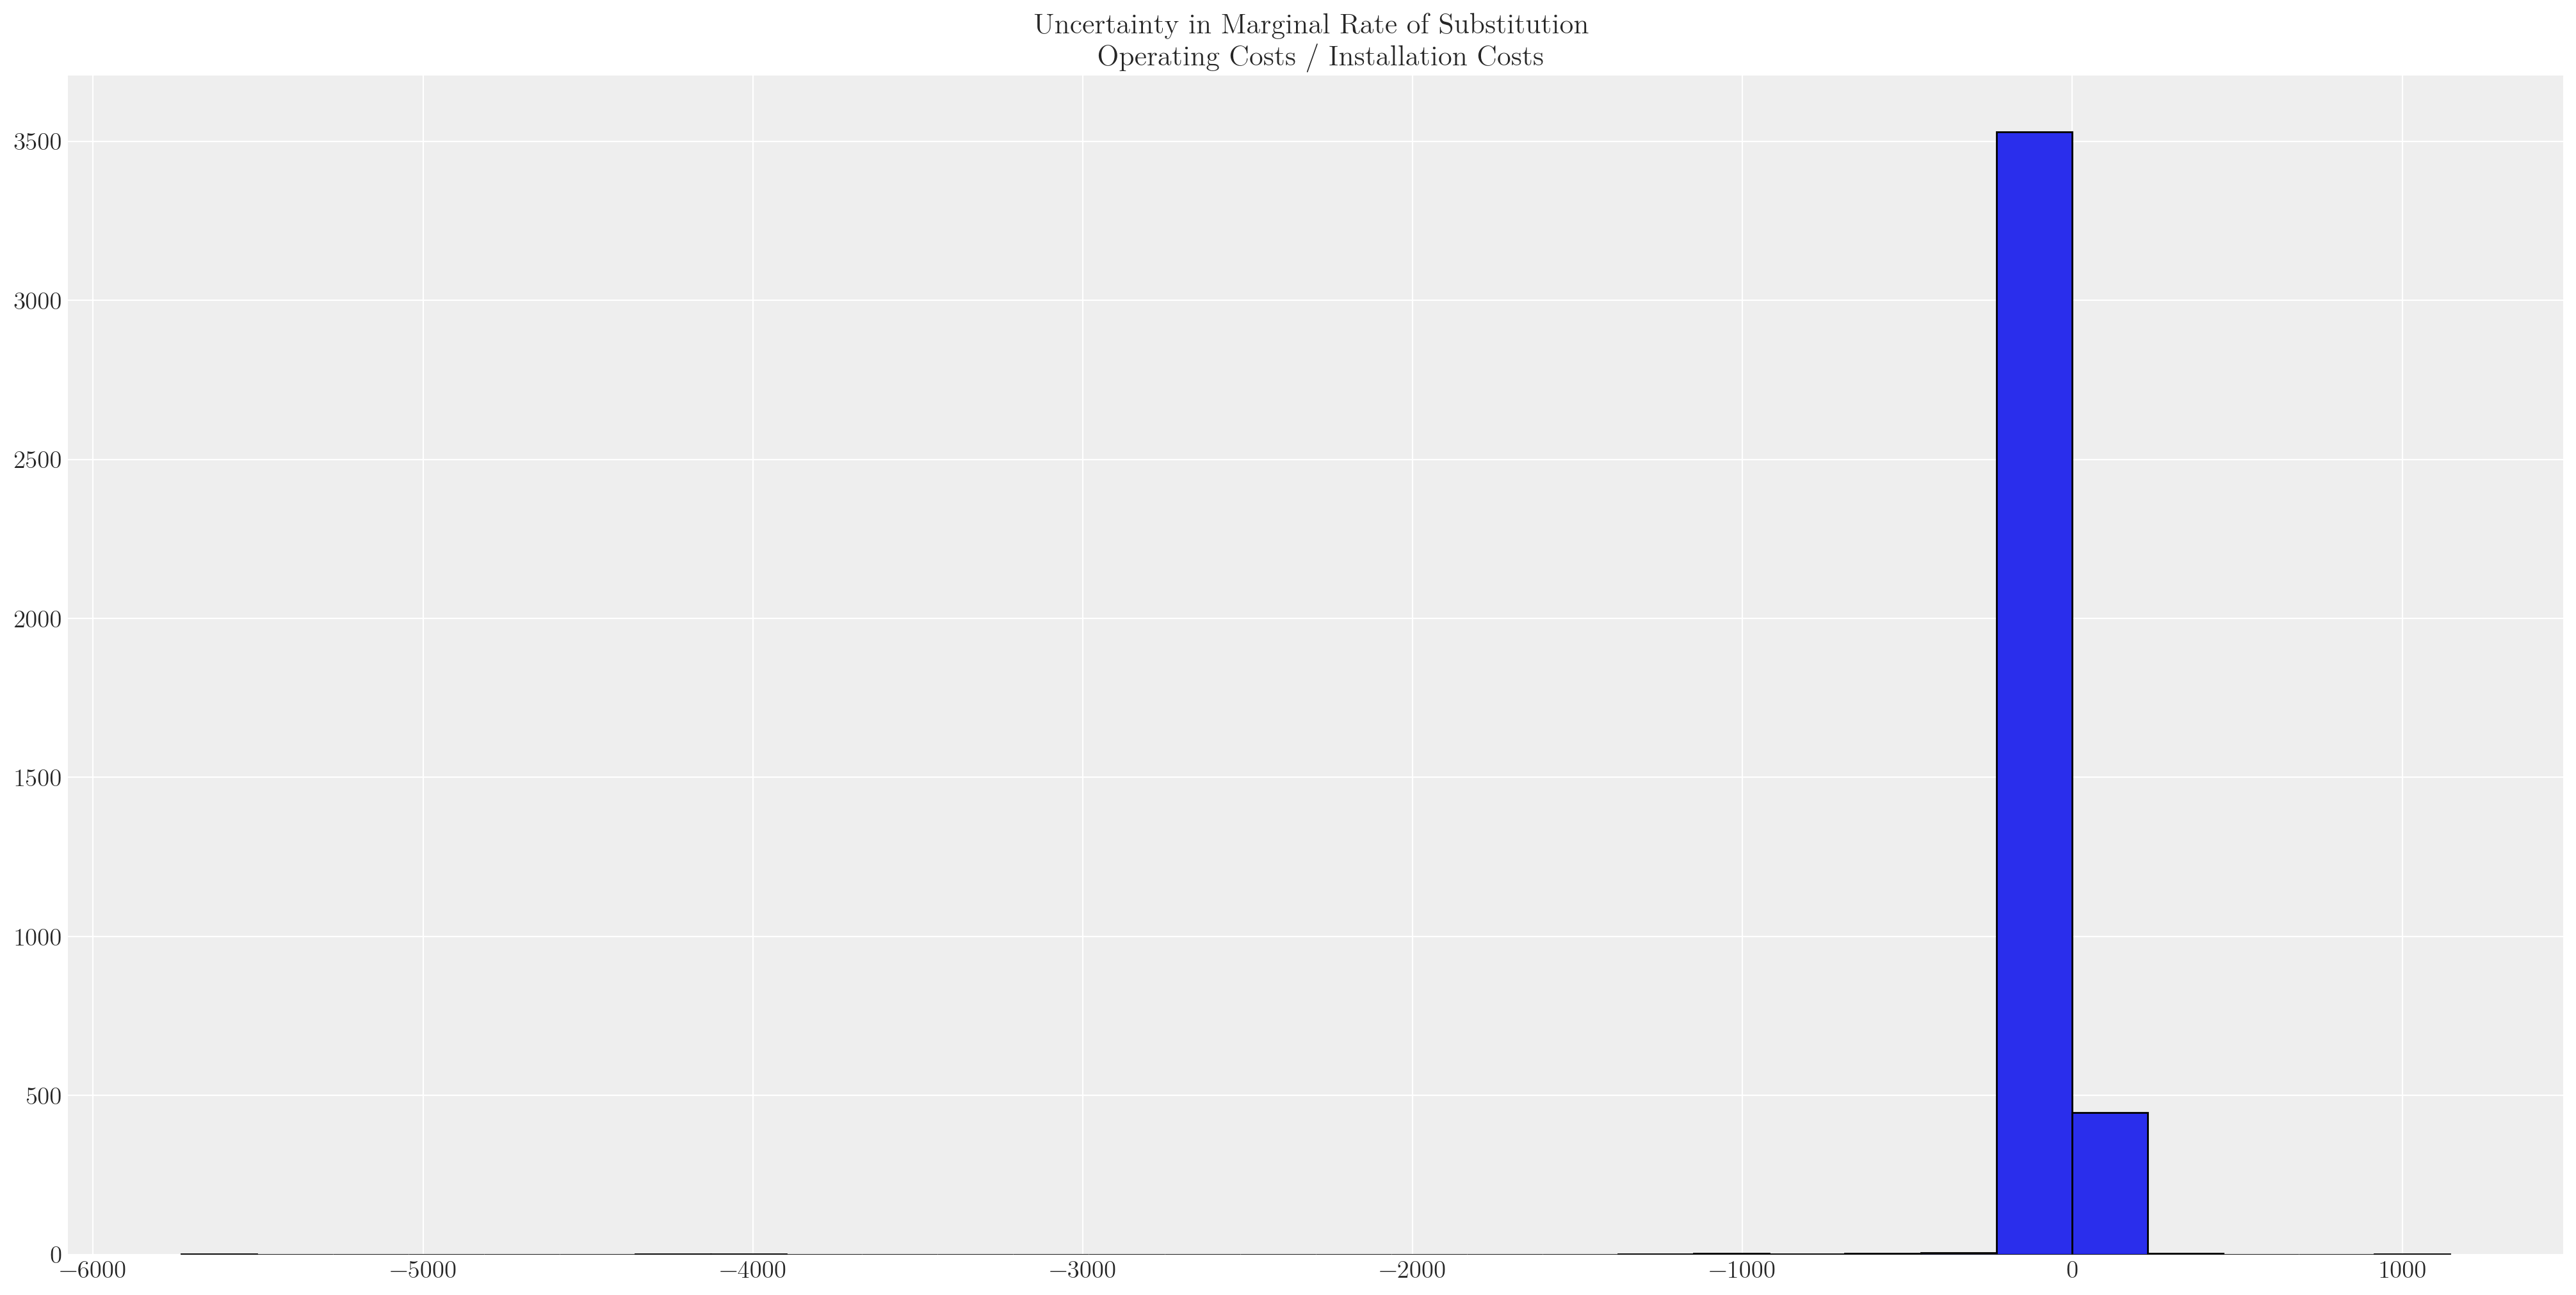

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");

# Bells and Whistles

Adding some cool extra features by:
- using a multivariate normal distirbution -- this allows for correlation among alternatives
- controlling for income in a log-affine fashion

Intuitively not sure how the correlation is identified, given that you only observe the actual choice

Sampling: [alpha, beta_ic, beta_income, beta_oc, chol, y_cat]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 713 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_cat]


Output()

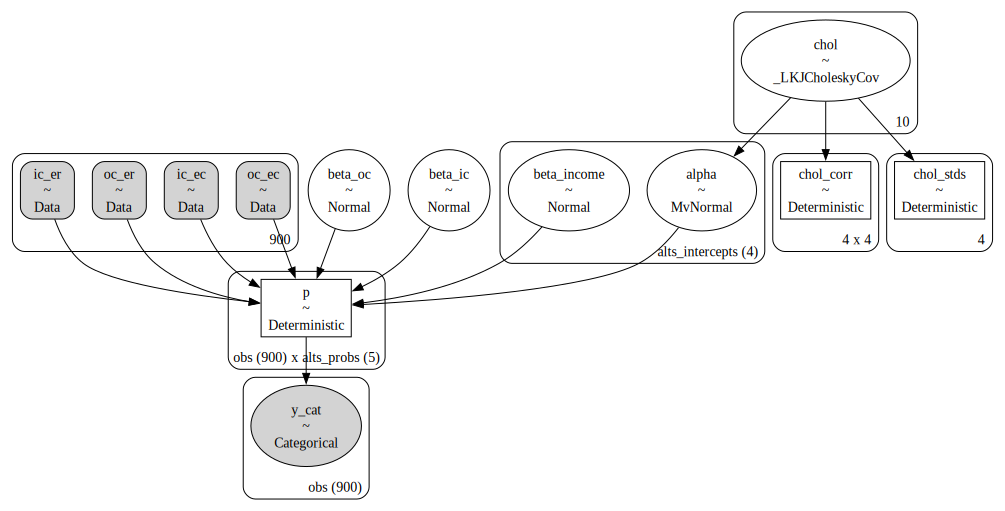

In [17]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_3:
    ## Add data to experiment with changes later.
    ic_ec = pm.Data("ic_ec", wide_heating_df["ic.ec"])
    oc_ec = pm.Data("oc_ec", wide_heating_df["oc.ec"])
    ic_er = pm.Data("ic_er", wide_heating_df["ic.er"])
    oc_er = pm.Data("oc_er", wide_heating_df["oc.er"])

    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=4, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    alphas = pm.MvNormal("alpha", mu=0, chol=chol, dims="alts_intercepts")

    u0 = alphas[0] + beta_ic * ic_ec + beta_oc * oc_ec + beta_income[0] * wide_heating_df["income"]
    u1 = alphas[1] + beta_ic * ic_er + beta_oc * oc_er + beta_income[1] * wide_heating_df["income"]
    u2 = (
        alphas[2]
        + beta_ic * wide_heating_df["ic.gc"]
        + beta_oc * wide_heating_df["oc.gc"]
        + beta_income[2] * wide_heating_df["income"]
    )
    u3 = (
        alphas[3]
        + beta_ic * wide_heating_df["ic.gr"]
        + beta_oc * wide_heating_df["oc.gr"]
        + beta_income[3] * wide_heating_df["income"]
    )
    u4 = np.zeros(N)  # pivot
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m3 = pm.sample_prior_predictive()
    idata_m3.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m3.extend(pm.sample_posterior_predictive(idata_m3))


pm.model_to_graphviz(model_3)

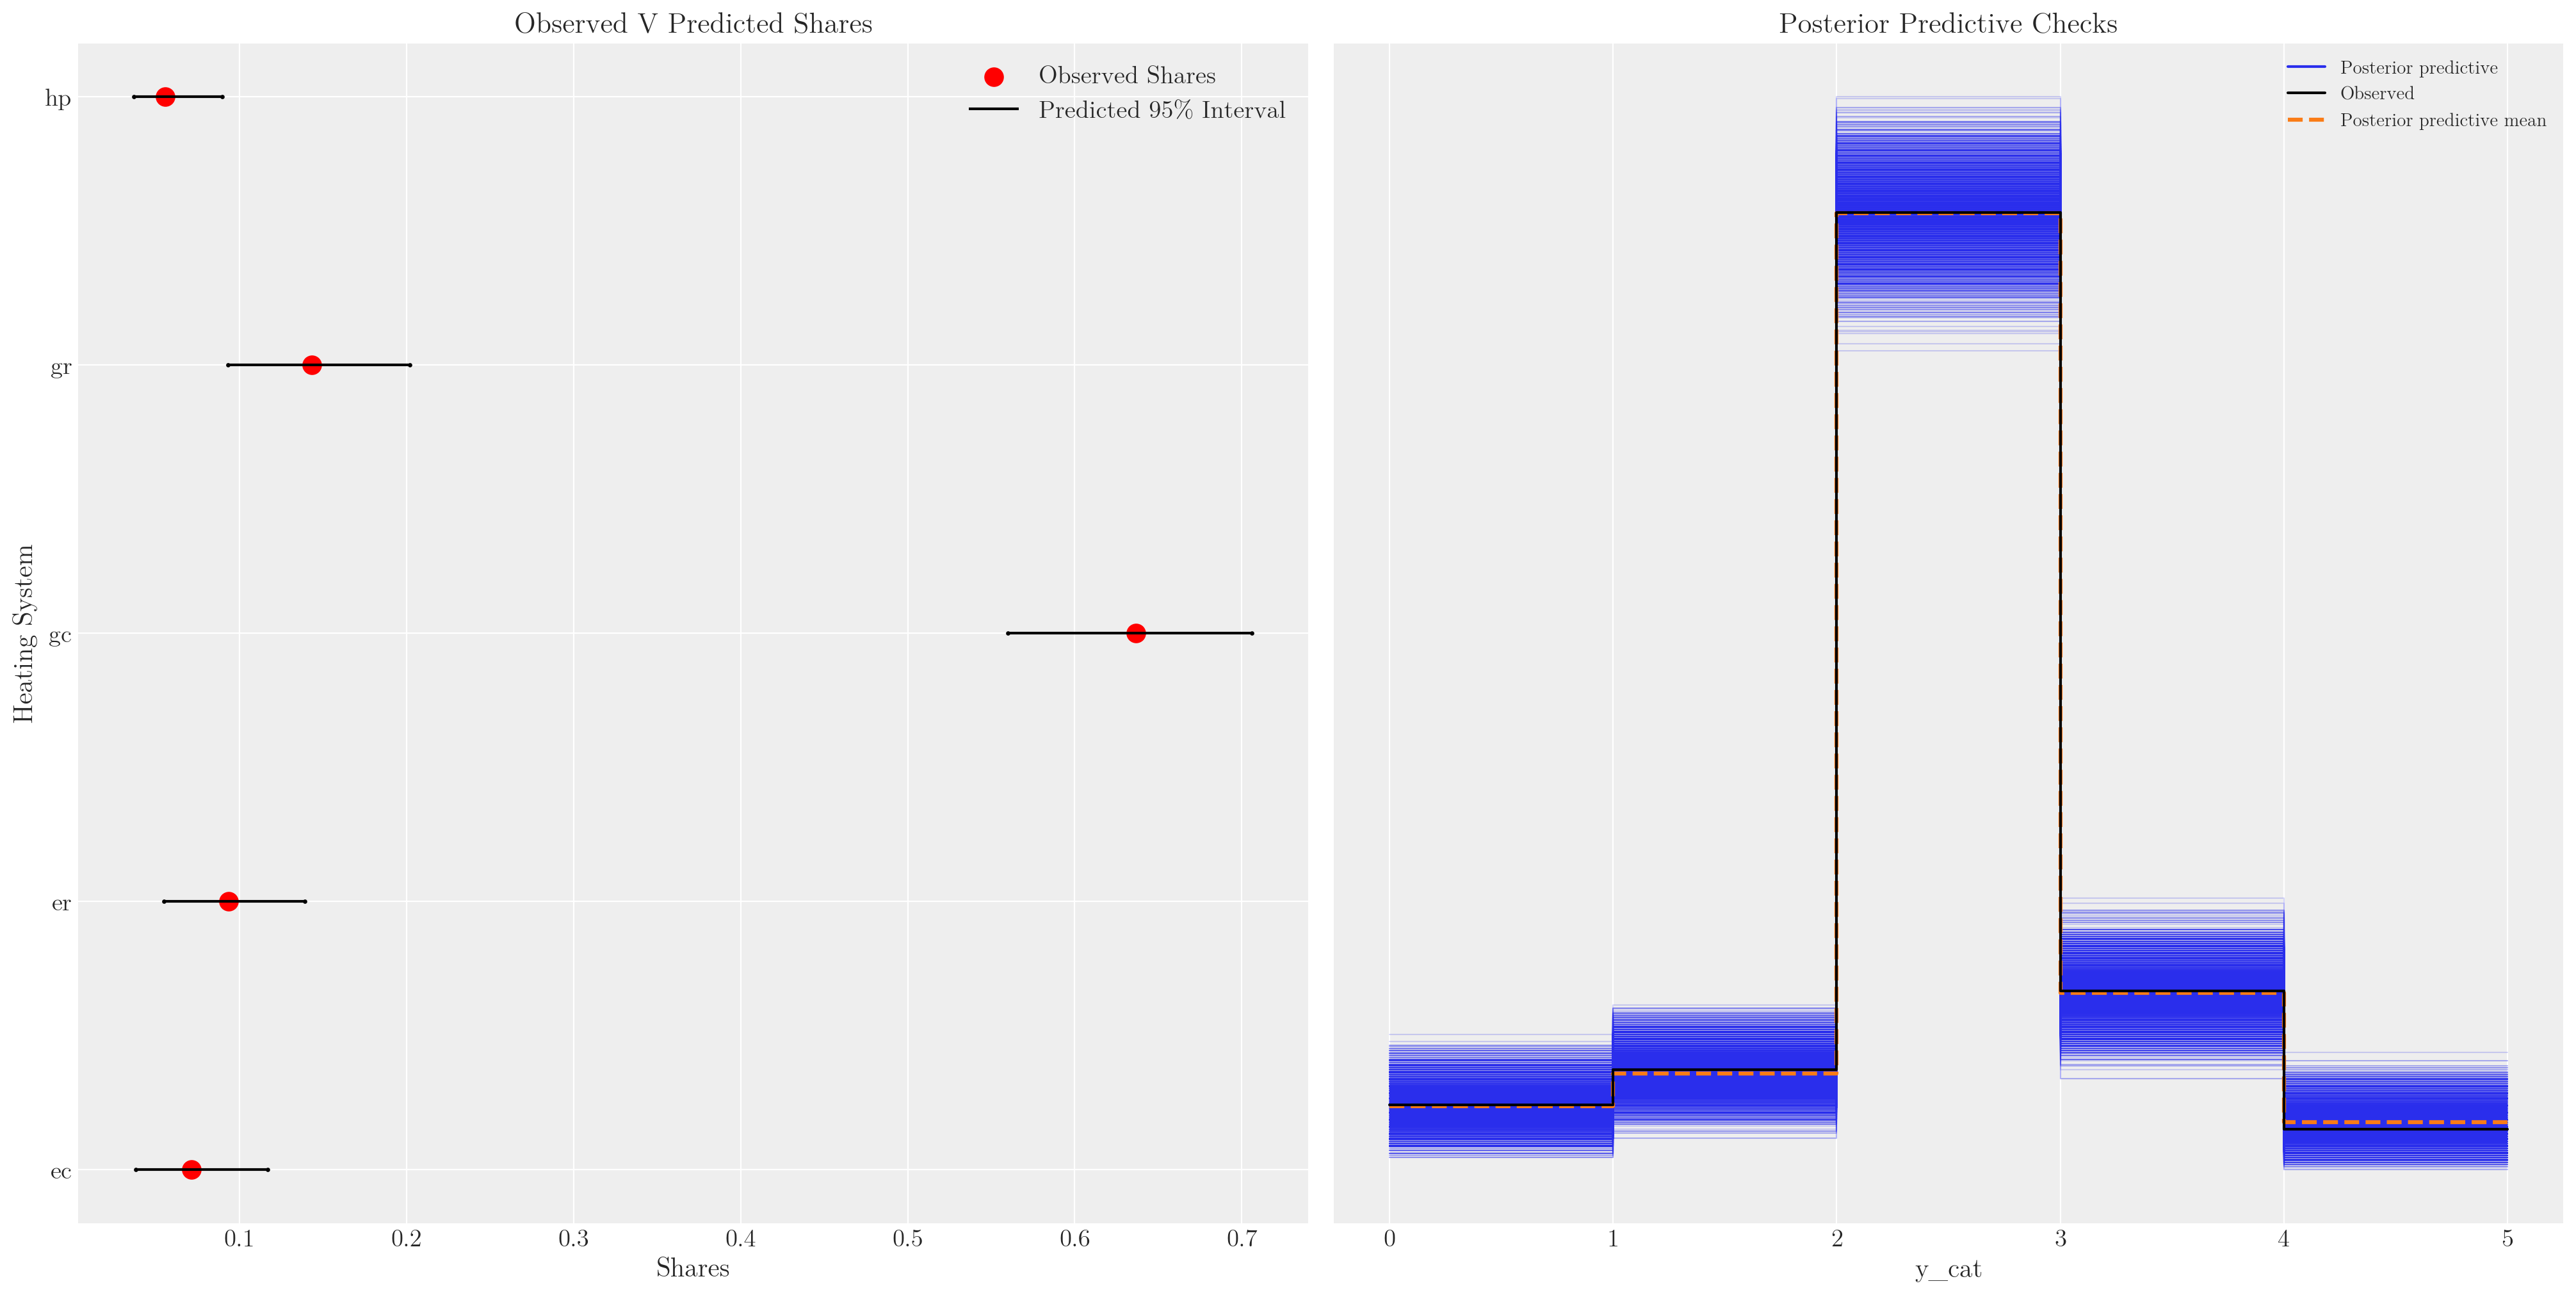

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m3["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m3["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m3["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m3, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [19]:
az.summary(
    idata_m3, var_names=["beta_income", "beta_ic", "beta_oc", "alpha", "chol_corr"], round_to=4
)

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_income[ec],0.1090,0.1045,-0.1194,0.2745,0.0111,0.0079,125.5245,1785.3613,1.0326
beta_income[er],0.0568,0.0985,-0.1462,0.2349,0.0034,0.0081,814.4173,1351.8588,1.1603
beta_income[gc],0.0701,0.0810,-0.0908,0.2230,0.0039,0.0028,514.8539,1447.0504,1.0928
beta_income[gr],-0.0182,0.0991,-0.2034,0.1530,0.0166,0.0119,43.2790,1394.2747,1.0660
beta_ic,0.0005,0.0007,-0.0008,0.0016,0.0002,0.0001,21.2834,1025.6984,1.1204
beta_oc,-0.0037,0.0014,-0.0063,-0.0008,0.0001,0.0001,130.7170,1819.1965,1.0273
alpha[ec],0.9330,1.0135,-0.4580,2.9612,0.1099,0.0780,361.4979,1033.9501,1.0793
alpha[er],1.1878,1.0135,-0.3409,3.1845,0.0761,0.0608,377.7638,1058.1381,1.1560
alpha[gc],2.2653,0.7507,1.2054,3.7209,0.1258,0.0897,46.5848,959.9773,1.0614
alpha[gr],1.0156,0.9110,-0.1379,2.6814,0.2079,0.1493,17.7565,40.8513,1.1541


In [20]:
post = az.extract(idata_m3)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

-13.242388002273604

# Tweaks

My preferred model is model 2, but with
- a control for income
- (ideally) set-constrained coefficients for installation cost and operating cost. However, this doesn't work. In practice it's because the coefficients are both so small (especially the $\beta_\text{installation cost}$) that constraining it is difficult

Because they're so small and so close to zero, it's also not meaningful to talk about a MRS.

Sampling: [alpha, beta_ic, beta_income, beta_oc, y_cat]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y_cat]


Output()

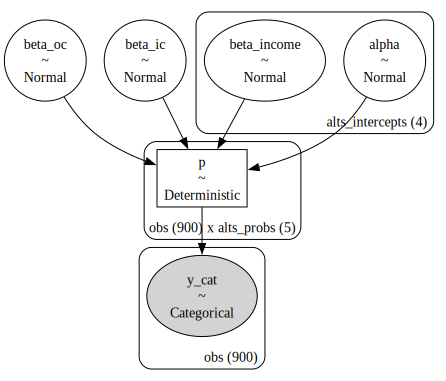

In [21]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model_4:
    beta_ic = pm.Normal("beta_ic")
    beta_oc = pm.Normal("beta_oc")
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    alphas = pm.Normal("alpha", 0, 5, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"] + beta_income[0] * wide_heating_df["income"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"] + beta_income[1] * wide_heating_df["income"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"] + beta_income[2] * wide_heating_df["income"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"] + beta_income[3] * wide_heating_df["income"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m4 = pm.sample_prior_predictive()
    idata_m4.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m4.extend(pm.sample_posterior_predictive(idata_m4))


pm.model_to_graphviz(model_4)

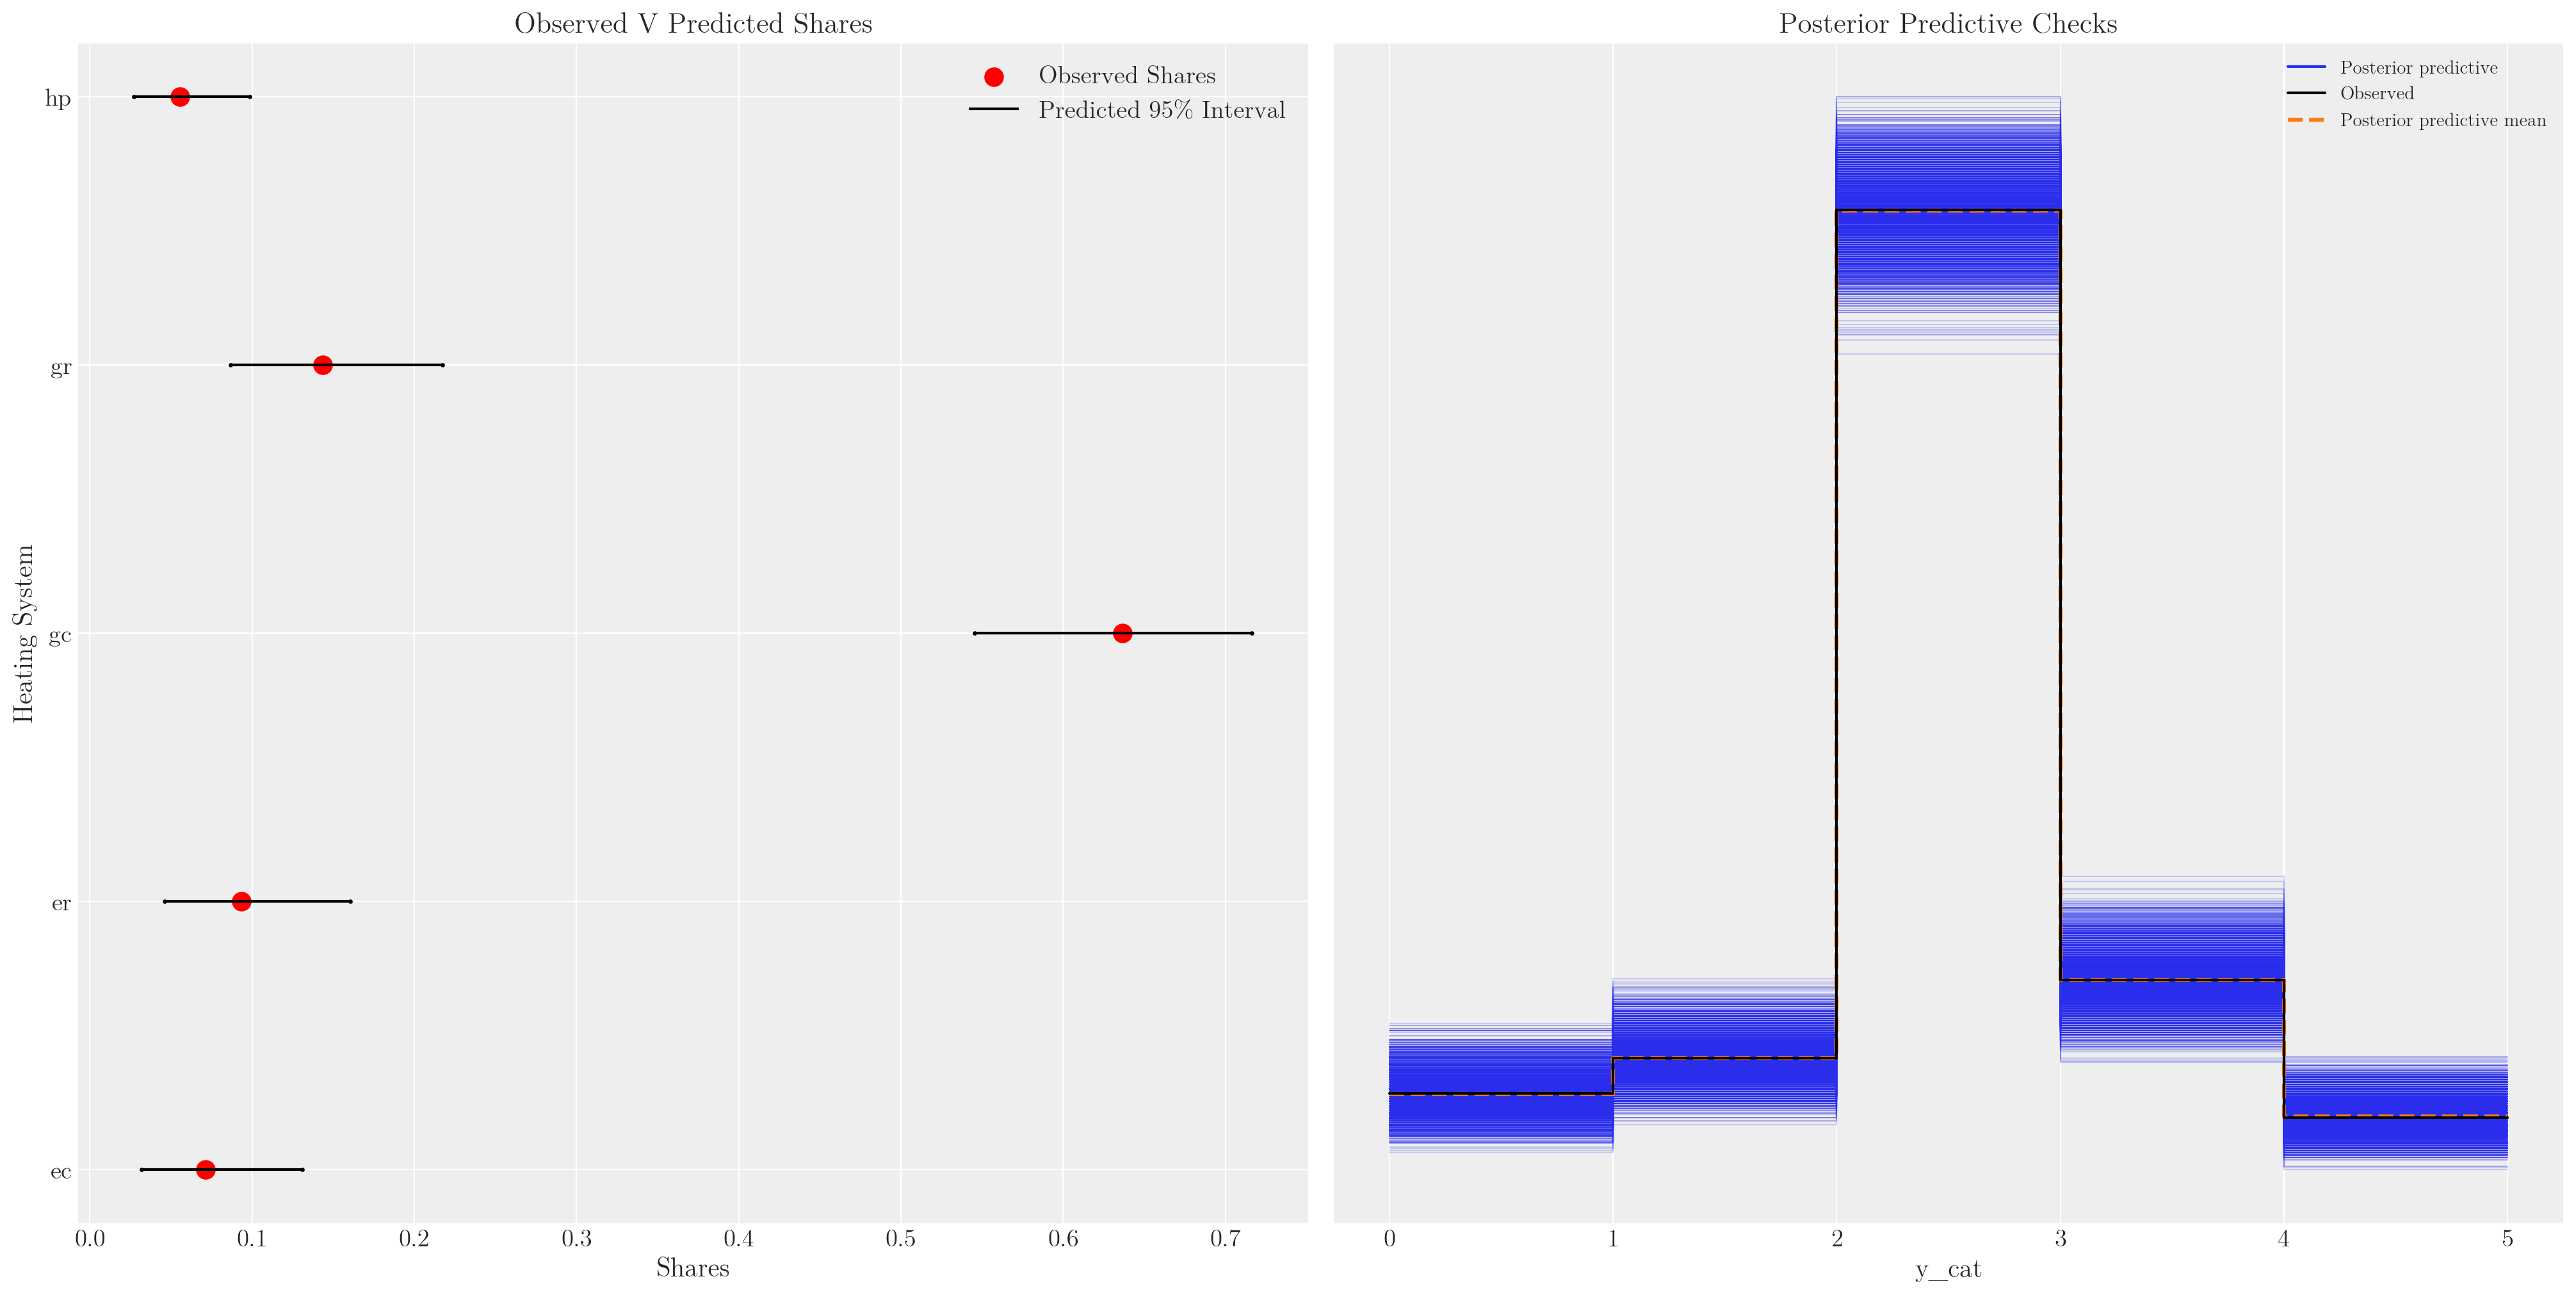

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m4["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m4["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m4["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m4, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [23]:
az.summary(
    idata_m4, var_names=["beta_ic", "beta_oc", "beta_income", "alpha"], round_to=4
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,-0.0007,0.0006,-0.0018,0.0004,0.0000,0.0000,2034.8098,2619.1608,1.0010
beta_oc,-0.0055,0.0015,-0.0081,-0.0025,0.0000,0.0000,2549.3952,3052.4259,1.0023
beta_income[ec],-0.0415,0.1123,-0.2552,0.1597,0.0032,0.0023,1233.5860,1949.2437,1.0024
beta_income[er],-0.0708,0.1064,-0.2544,0.1412,0.0031,0.0022,1151.0759,1873.4452,1.0022
beta_income[gc],-0.0527,0.0866,-0.2195,0.1042,0.0027,0.0019,1063.0967,1595.1725,1.0012
beta_income[gr],-0.1619,0.0990,-0.3460,0.0231,0.0029,0.0021,1134.4858,1809.5429,1.0011
alpha[ec],3.5846,0.9338,1.9701,5.4876,0.0286,0.0204,1066.7882,1428.9757,1.0018
alpha[er],3.8573,0.9128,2.1368,5.5381,0.0294,0.0210,968.1931,1275.9228,1.0013
alpha[gc],4.1892,0.6397,2.9483,5.3714,0.0211,0.0150,918.4178,1199.7850,1.0012
alpha[gr],3.1823,0.7224,1.8973,4.5941,0.0232,0.0165,967.8811,1118.1689,1.0017


In [24]:
post = az.extract(idata_m4)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

31.17482352077738

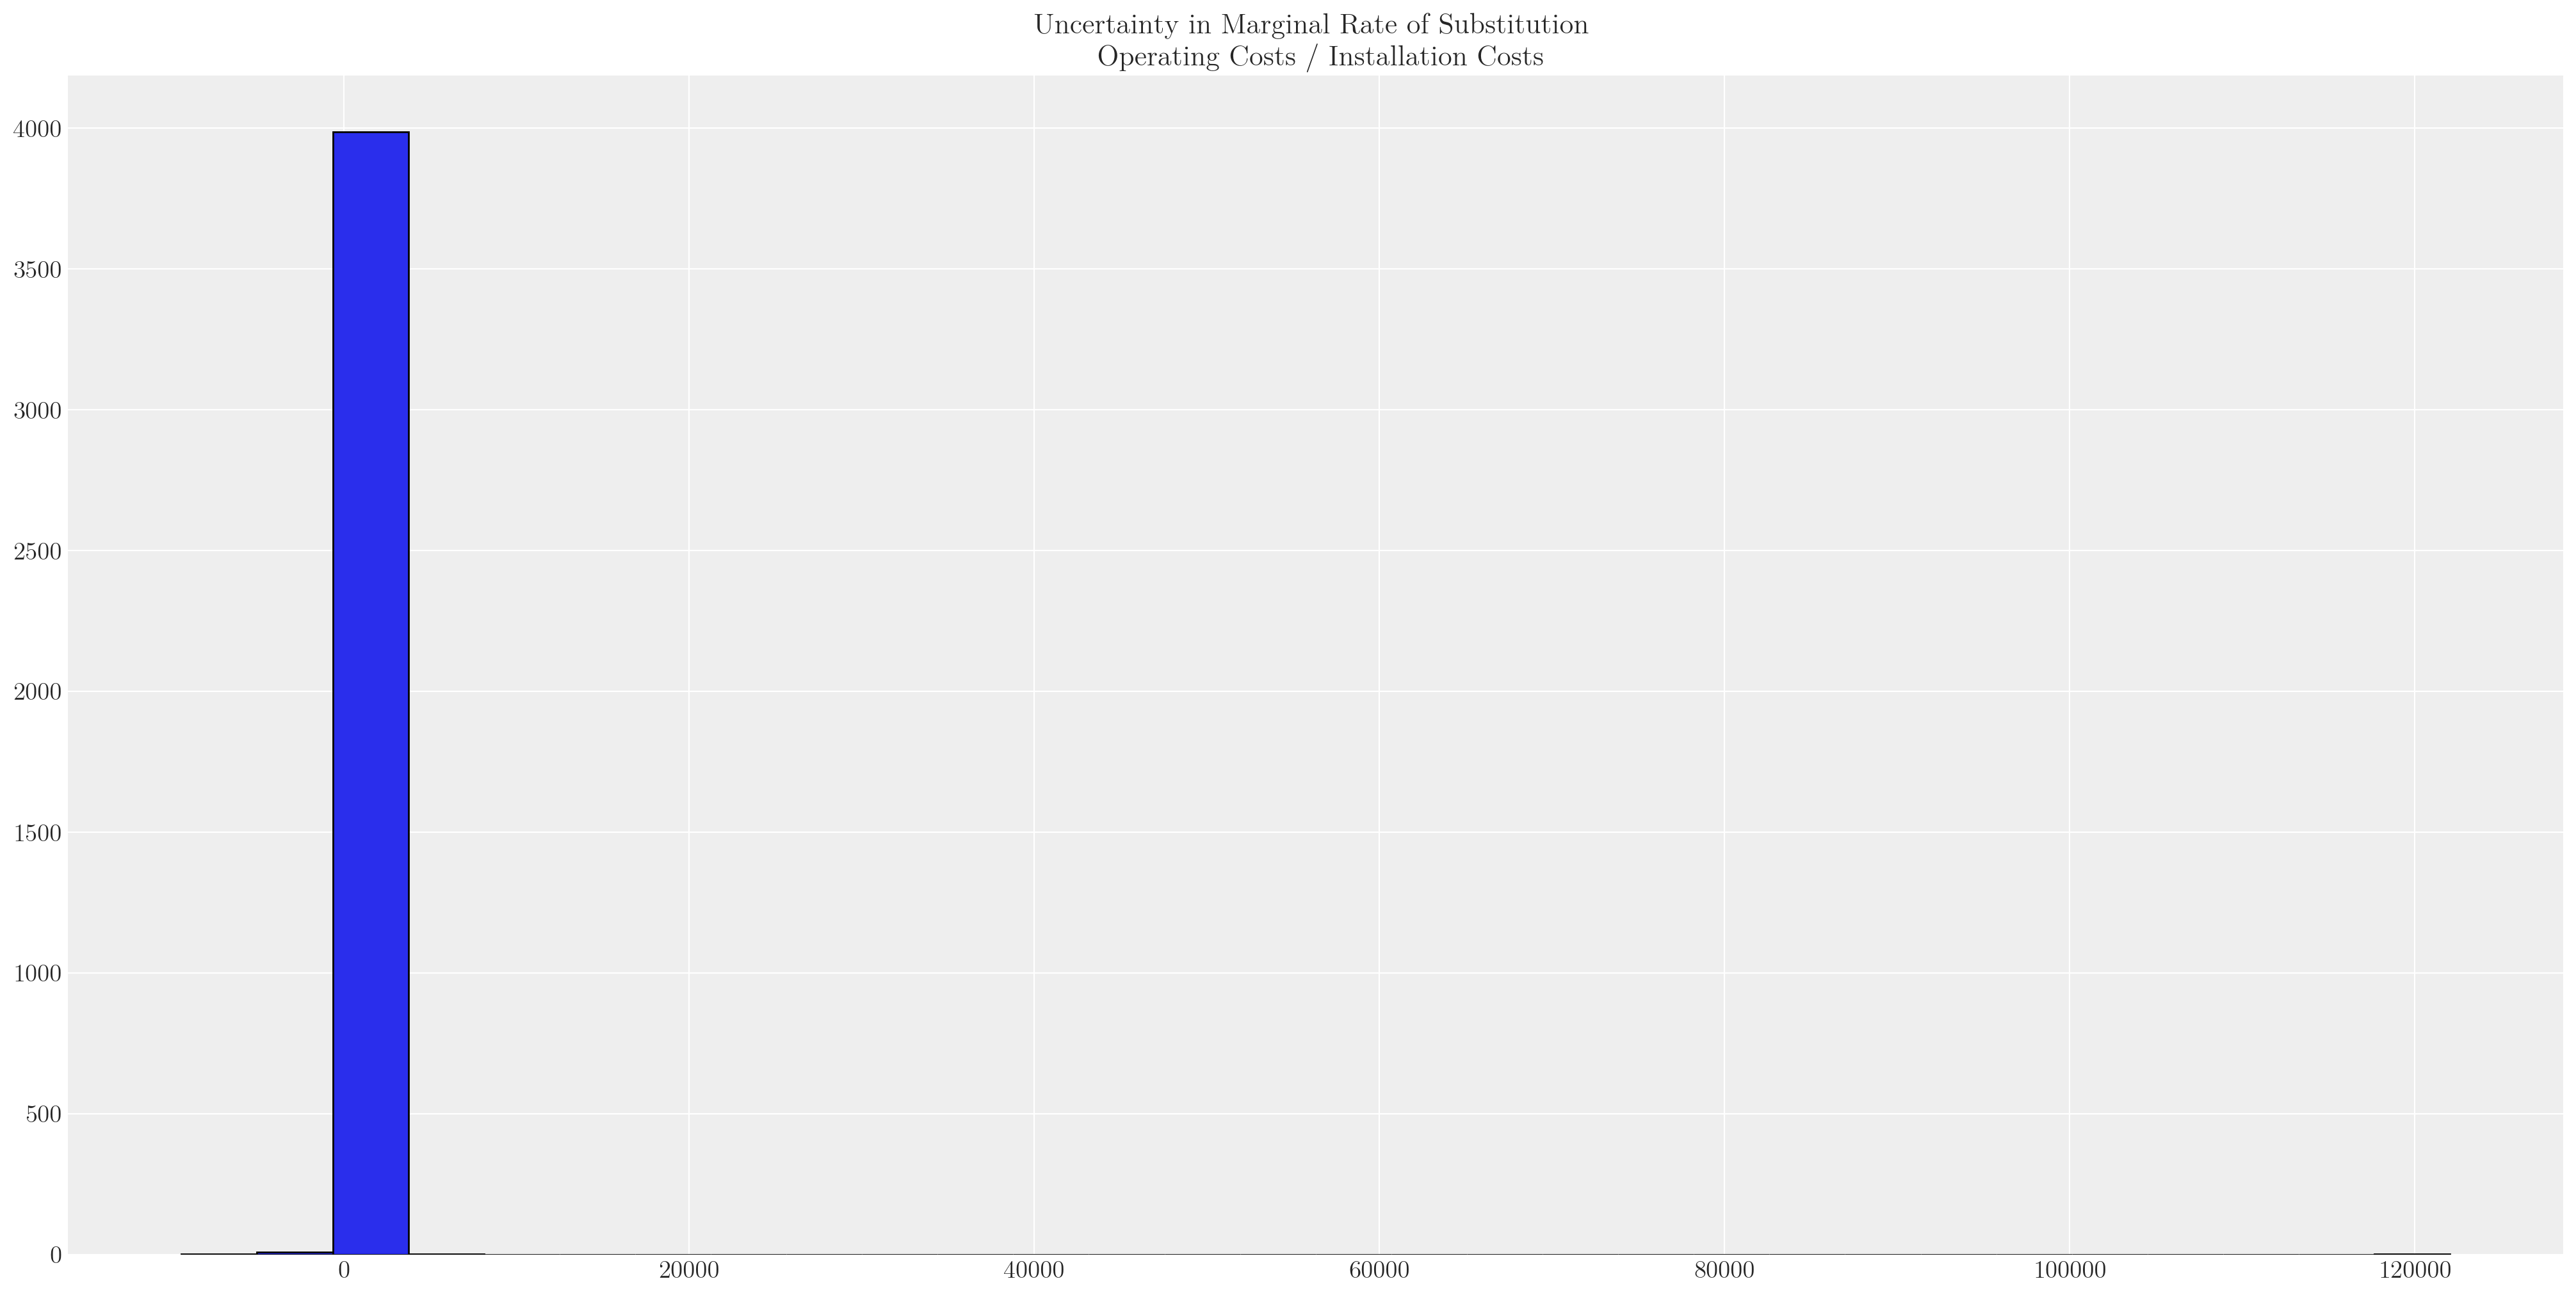

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");

# Counterfactuals

In [26]:
with model_3:
    # update values of predictors with new 20% price increase in operating costs for electrical options
    pm.set_data({"oc_ec": wide_heating_df["oc.ec"] * 1.2, "oc_er": wide_heating_df["oc.er"] * 1.2})
    # use the updated values and predict outcomes and probabilities:
    idata_new_policy = pm.sample_posterior_predictive(
        idata_m3,
        var_names=["p", "y_cat"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        random_seed=100,
    )

idata_new_policy

Sampling: [y_cat]


Output()

Inference data with groups:
	> predictions
	> predictions_constant_data

In [27]:
idata_new_policy["predictions"]["p"].mean(dim=["chain", "draw", "obs"])

<xarray.DataArray 'p' (alts_probs: 5)> Size: 40B
array([0.05293203, 0.07065756, 0.66509458, 0.14841689, 0.06289894])
Coordinates:
  * alts_probs  (alts_probs) <U2 40B 'ec' 'er' 'gc' 'gr' 'hp'

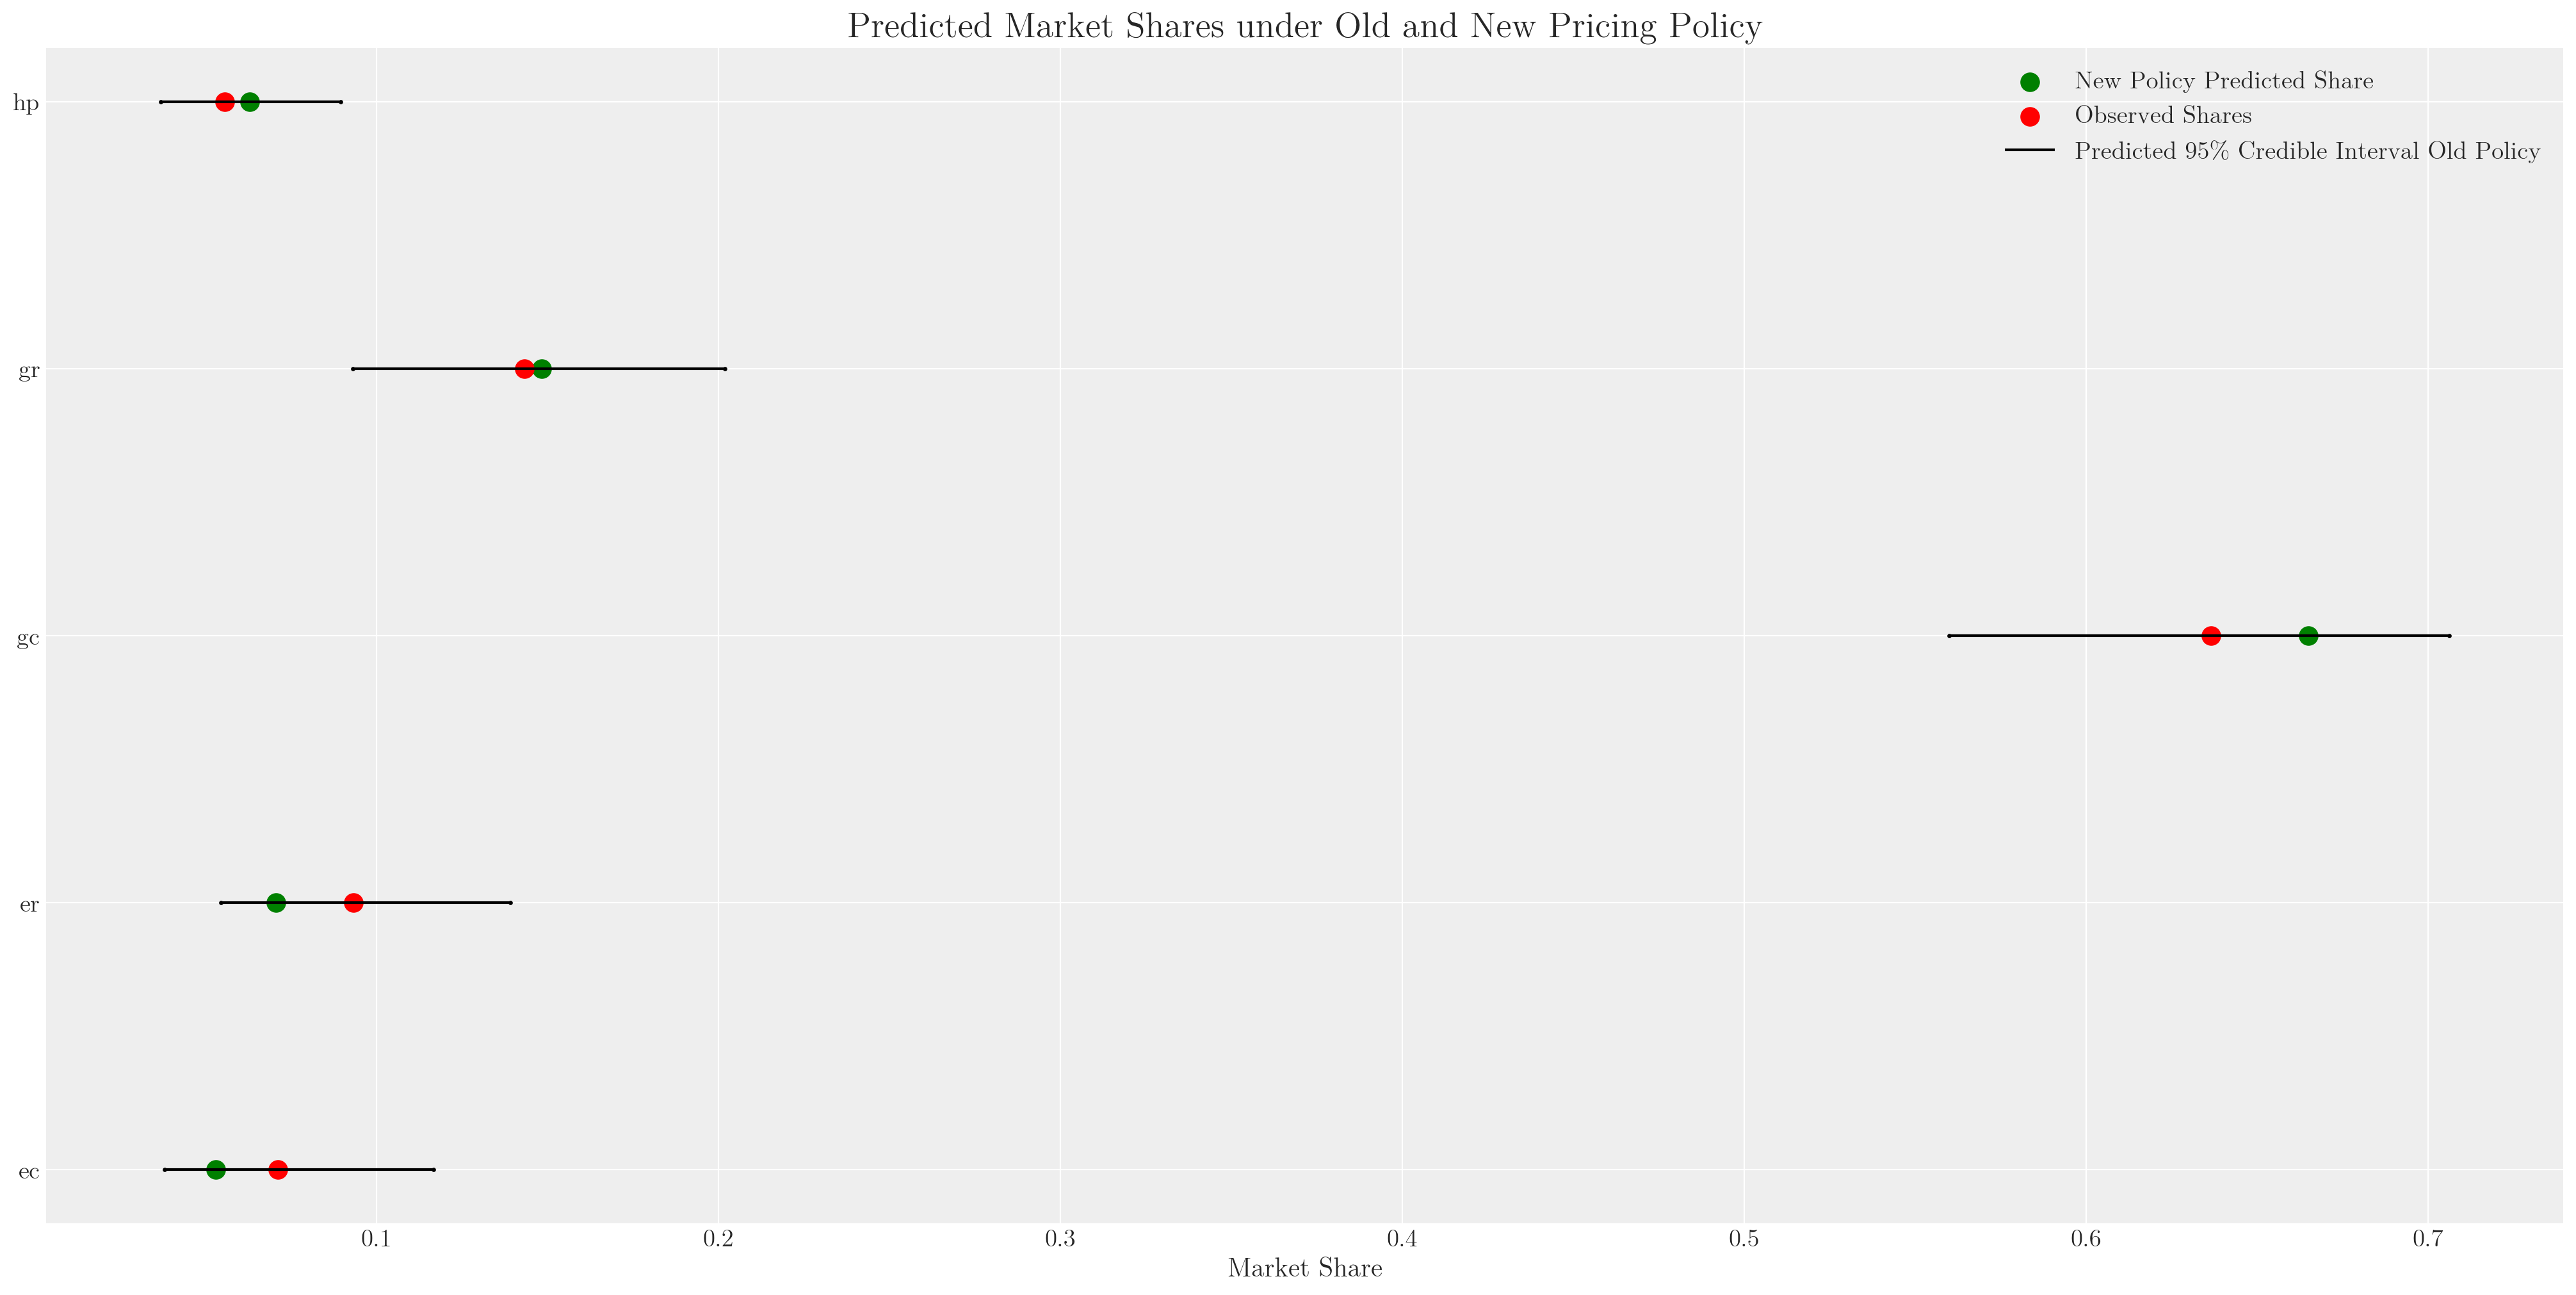

In [28]:
fig, ax = plt.subplots(1, figsize=(20, 10))
counts = wide_heating_df.groupby("depvar")["idcase"].count()
new_predictions = idata_new_policy["predictions"]["p"].mean(dim=["chain", "draw", "obs"]).values
ci_lb = idata_m3["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m3["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    new_predictions,
    ["ec", "er", "gc", "gr", "hp"],
    color="green",
    label="New Policy Predicted Share",
    s=100,
)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"],
    ci_lb,
    ci_ub,
    label="Predicted 95% Credible Interval Old Policy",
    color="black",
)
ax.set_title("Predicted Market Shares under Old and New Pricing Policy", fontsize=20)
ax.set_xlabel("Market Share")
ax.legend();

# Compare models

In [29]:
compare = az.compare({"m1": idata_m1, "m2": idata_m2, "m3": idata_m3, "m4": idata_m4})
compare

/Users/gzheng/projects/professional/likert_dualresponse/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m4,0,-1020.574185,9.992352,0.000000,7.557224e-01,28.247545,0.000000,False,log
m2,1,-1023.552608,5.038925,2.978423,2.305736e-01,27.799085,3.623620,False,log
m3,2,-1025.780290,9.345972,5.206104,1.972889e-13,28.163863,3.007272,True,log
m1,3,-1309.642978,1.228472,289.068792,1.370393e-02,12.918328,23.321276,False,log
